In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
from fastai.vision import *

In [22]:
path = Path('/kaggle/input/planets-dataset/planet/planet')
path.ls()


[PosixPath('/kaggle/input/planets-dataset/planet/planet/train_classes.csv'),
 PosixPath('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv'),
 PosixPath('/kaggle/input/planets-dataset/planet/planet/train-jpg'),
 PosixPath('/kaggle/input/planets-dataset/planet/planet/test-jpg')]

In [23]:
df = pd.read_csv(path/'train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [24]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [25]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

/opt/conda/lib/python3.7/site-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [26]:
data = (src.transform(tfms, size=128)
        .databunch(num_workers=0).normalize(imagenet_stats))

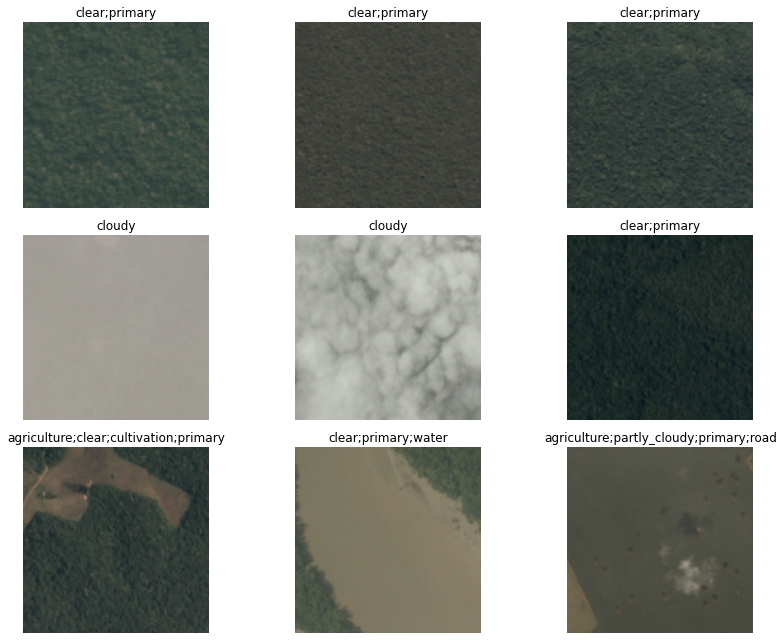

In [27]:
data.show_batch(rows=3, figsize=(12,9))

In [28]:
arch = models.resnet50

In [29]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score], model_dir='/tmp/models')

In [30]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


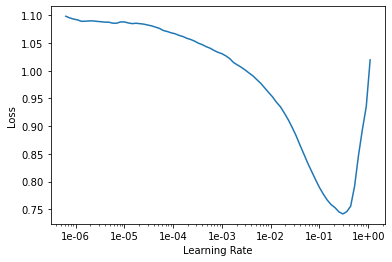

In [31]:
learn.recorder.plot()

In [32]:
lr = 0.01

In [33]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.134558,0.118187,0.947876,0.900286,04:39
1,0.114097,0.101014,0.954402,0.913603,04:55
2,0.100428,0.092812,0.955557,0.920579,05:00
3,0.095592,0.089024,0.956030,0.923568,04:57
4,0.093107,0.087133,0.956262,0.925864,04:51


In [34]:
learn.save('stage-1-rn50')

In [35]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


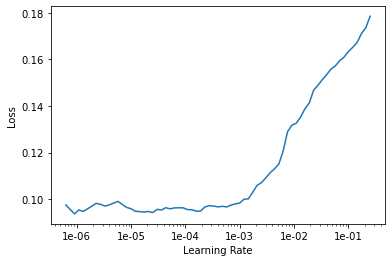

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095276,0.091135,0.954925,0.920352,05:10
1,0.098936,0.089002,0.953559,0.923441,05:04
2,0.092116,0.086475,0.956037,0.924969,05:19
3,0.083378,0.083620,0.958667,0.927833,05:06
4,0.080500,0.082610,0.958624,0.928751,04:50


In [38]:
learn.save('stage-2-rn50')

In [39]:
data = (src.transform(tfms, size=256)
        .databunch(num_workers=0).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [40]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


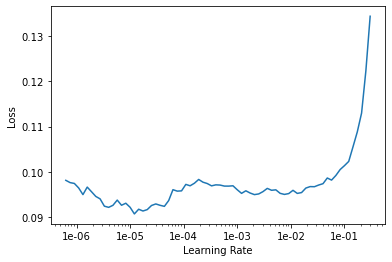

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
lr=1e-2/2

In [43]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087096,0.085801,0.956102,0.924762,08:45
1,0.089852,0.083745,0.959619,0.927007,09:02
2,0.086102,0.082936,0.958406,0.927880,09:18
3,0.080661,0.081350,0.957810,0.929382,09:22
4,0.078782,0.081350,0.960201,0.930171,09:14


In [44]:
learn.save('stage-1-256-rn50')

In [45]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085439,0.083968,0.959082,0.929473,10:15
1,0.085202,0.084131,0.956829,0.926363,10:03
2,0.079659,0.083021,0.958980,0.926989,10:38
3,0.078862,0.080853,0.958290,0.930146,10:39
4,0.074533,0.080998,0.959358,0.930421,10:29


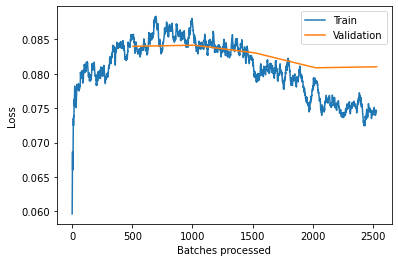

In [47]:
learn.recorder.plot_losses()

In [48]:
learn.save('stage-2-256-rn50')